In [3]:
from nixtlats import TimeGPT

/Users/leslyguerrero/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [16]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

In [4]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'Kq8fWoKewedmw9cF7mCR2X9WVvS9cZghj77NfzowuFZNq3HTZMYNjhyOxjOSgPN5QsgEC2upWEYquehAlGGo2DLpoZVm4gBaIEoMx3UDwelBA68rseW0ElKEXZltviyIm7HlK49U3sILJzfAvhnlda5ZImmTpN3GwBZtqOc9tIeTbtwW539HiykWIucPWqrK07j2jDQ8AqShZnC1obV3ujSkkXb0Jz11Wrsmw9nszXut79TzJ1AEltnowVcY3ITD'
)

In [5]:
timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [17]:
def interpolate_columns_with_year_month(df):
    df=df.copy()
    df.index = pd.to_datetime(df.index)
    
    # Apply interpolation logic to each column
    for column in df.columns:
        # Fill within the same year and month for each column
        yearly_monthly_hourly_avg = df.groupby([df.index.year, df.index.month, df.index.hour])[column].transform('mean')
        df[column].fillna(yearly_monthly_hourly_avg, inplace=True)
        
        # Check and fill any remaining NaNs in the column
        if df[column].isna().any():
            # Calculate the overall hourly average for the column as a fallback
            overall_hourly_avg = df.groupby(df.index.hour)[column].transform('mean')
            
            for time, _ in df[df[column].isna()].iterrows():
                df.at[time, column] = overall_hourly_avg[time.hour]
    
    return df

In [18]:
def process_data(data):
    df = data.copy()
    #convert index to datetime
    df.index = pd.to_datetime(df.index)
    duplicate_labels = df.index.duplicated()
    df = df[~duplicate_labels]
    df = df.resample('H').mean()
    df = df.reindex(pd.date_range(start=data.index.min(), end=data.index.max(), freq='H'))
    interpolation = interpolate_columns_with_year_month(df)
    return interpolation

In [25]:
dataset = pd.read_pickle("colchester_cleaned.pkl")
dataset = dataset['windpower'].to_frame()
# Use only data from 2000-01-01 to 2022-11-31 for the train, for validation use data from 2022-12-01 to 2022-12-31 and for test from 2023-01-01 to 2024-01-05
train = process_data(dataset.loc[:'2023-12-30'])
validation = process_data(dataset.loc['2023-12-31'])
test = process_data(dataset.loc['2024-01-01':])

In [26]:
train.reset_index(inplace=True)
train = train.rename(columns={'index': 'timestamp','windpower':'value'})
train.head()

,timestamp,value
0,2000-01-01 00:00:00,4.901388e+05
1,2000-01-01 01:00:00,2.570771e+06
2,2000-01-01 02:00:00,1.921775e+06
3,2000-01-01 03:00:00,2.023435e+06
4,2000-01-01 04:00:00,2.132902e+06


In [28]:
validation.reset_index(inplace=True)
validation = validation.rename(columns={'index': 'timestamp','windpower':'value'})
validation.head()

,timestamp,value
0,2023-12-31 00:00:00,1.027500e+07
1,2023-12-31 01:00:00,1.027500e+07
2,2023-12-31 02:00:00,1.027500e+07
3,2023-12-31 03:00:00,1.025056e+07
4,2023-12-31 04:00:00,8.672802e+06


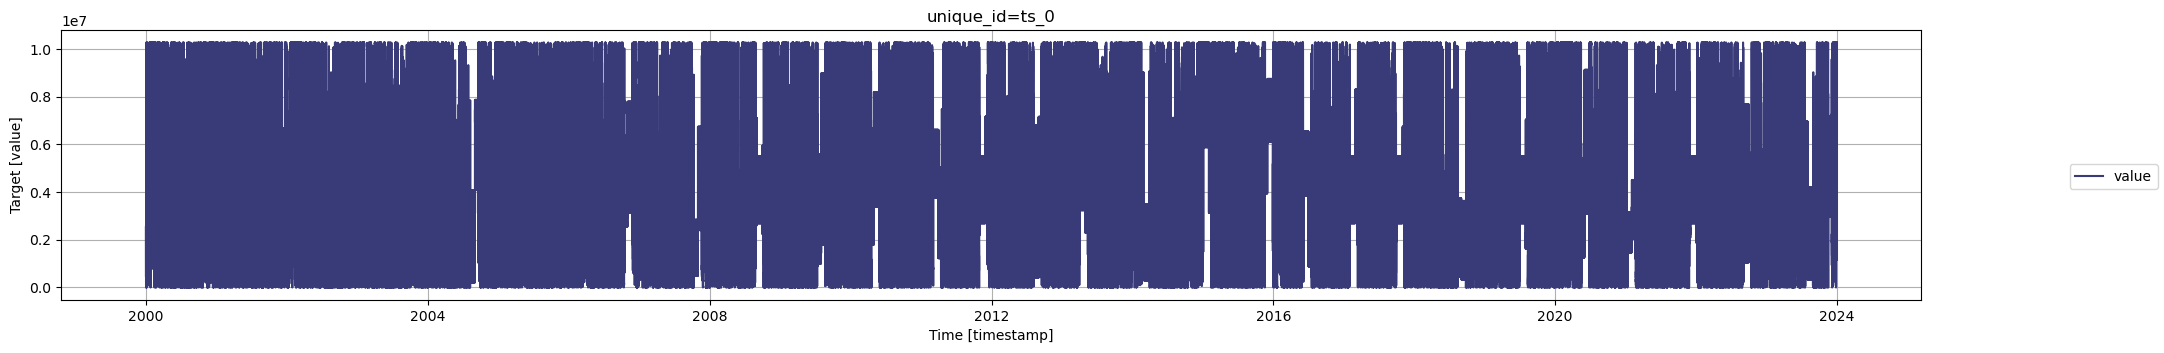

In [27]:
timegpt.plot(train, time_col='timestamp', target_col='value')

In [29]:
timegpt_fcst_df = timegpt.forecast(df=train, h=24, freq='H', time_col='timestamp', target_col='value')
timegpt_fcst_df.head()


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,timestamp,TimeGPT
0,2023-12-31 00:00:00,10894355.0
1,2023-12-31 01:00:00,10535088.0
2,2023-12-31 02:00:00,10426159.0
3,2023-12-31 03:00:00,10206119.0
4,2023-12-31 04:00:00,9963922.0


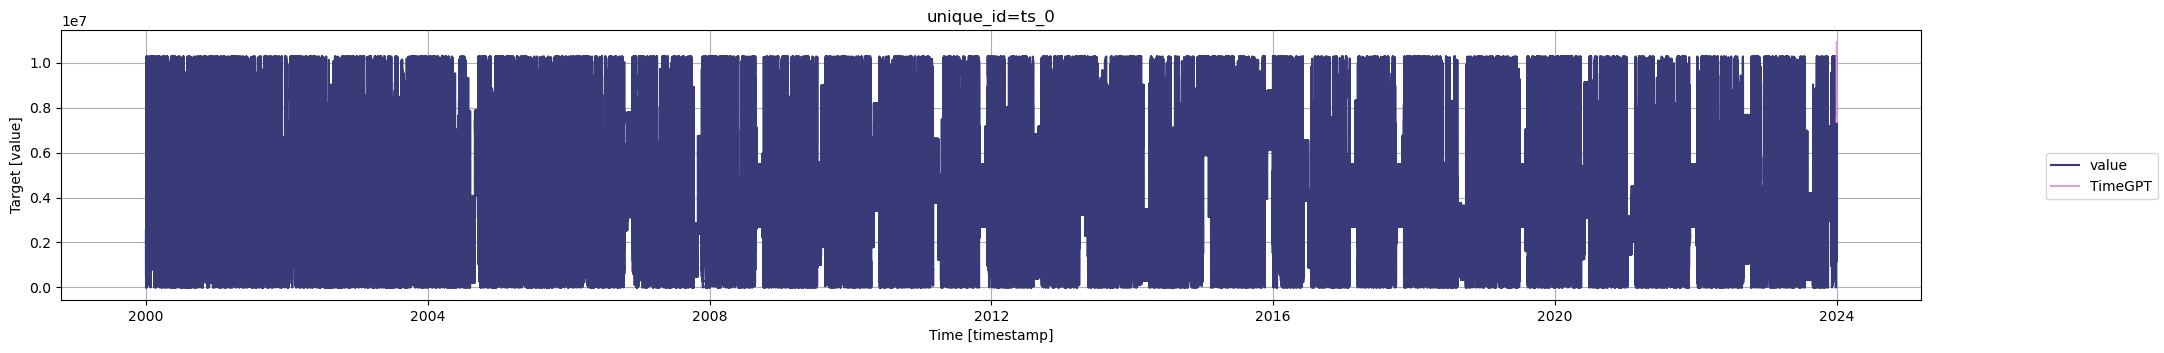

In [30]:
timegpt.plot(train, timegpt_fcst_df, time_col='timestamp', target_col='value')


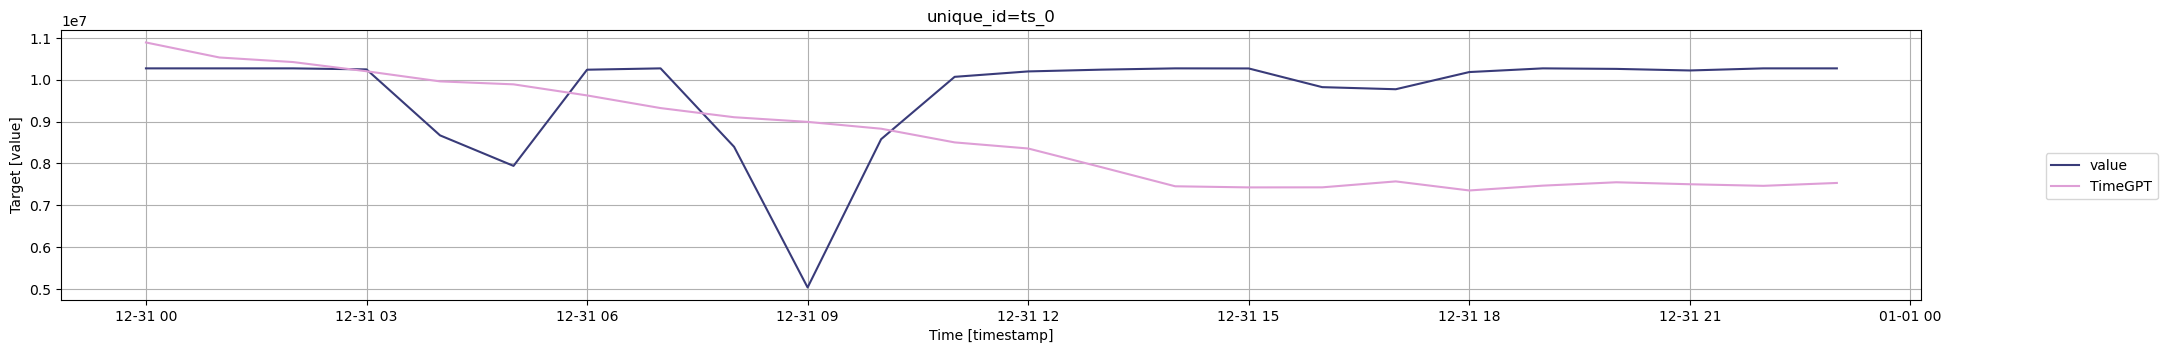

In [39]:
timegpt.plot(validation, timegpt_fcst_df, time_col='timestamp', target_col='value')


In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [20]:
def measure_forecast_error(label, forecast):
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f (W)' % mean_absolute_error(label, forecast))
    print('MAPE = %.2f%%' % (100*mean_absolute_percentage_error(label, forecast)))
    print('R2 = %.2f' % r2_score(label, forecast))

In [34]:
measure_forecast_error(validation['value'], timegpt_fcst_df['TimeGPT'])

MAE = 1809487.43 (W)
MAPE = 19.82%
R2 = -2.17


In [35]:
# save pred to a pickle
timegpt_fcst_df.to_pickle('timegpt_pre.pkl')

## Autoarima

In [4]:
from pmdarima import auto_arima

In [5]:
dataset = pd.read_pickle("colchester_cleaned.pkl")
#dataset = dataset['windpower'].to_frame()
# Use only data from 2000-01-01 to 2022-11-31 for the train, for validation use data from 2022-12-01 to 2022-12-31 and for test from 2023-01-01 to 2024-01-05
train_arima = process_data(dataset.loc['2022-12-30':'2023-12-30'])
validation_arima = process_data(dataset.loc['2023-12-31'])
test_arima = process_data(dataset.loc['2024-01-01':])

In [14]:
arima_model = auto_arima(train_arima, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=24, start_P=0, 
                          max_d=4,
                          seasonal=True, d=1, D=1, trace=True,
                            error_action='warn', suppress_warnings=True, 
                            stepwise=True,random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=17.75 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=273450.167, Time=3.21 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=271264.131, Time=17.94 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=26.95 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=273421.695, Time=3.86 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=270541.163, Time=63.89 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=159.44 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=34.74 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=269940.346, Time=58.89 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=270957.494, Time=15.97 sec
 ARIMA(0,1,0)(2,1,1)[24]             : AIC=inf, Time=109.81 sec
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=inf, Time=35.11 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=270541.558, Time=62.30 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=270541.228, Time=157.46 sec
 ARIMA(0,1,0)(2,1,

In [15]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8784
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 24)   Log Likelihood             -134967.173
Date:                            Tue, 19 Mar 2024   AIC                         269940.346
Time:                                    16:51:45   BIC                         269961.580
Sample:                                12-30-2022   HQIC                        269947.581
                                     - 12-30-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.6628      0.007    -91.845      0.000      -0.677      -0.649
ar.S.L48      -0.3320      0.008    -43.289      0.000      -0.347      -0.317
sigma2      1.415e+12   2.04e-16   6.92e+27      0.000    1.41e+12    1.41e+12
===================================================================================
Ljung-Box (L1) (Q):                  17.42   Jarque-Bera (JB):              7357.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+43. Standard errors may be unstable.
"""

In [21]:
# build SARIMAX(0, 1, 0)x(2, 1, 0, 24)
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(train_arima['windpower'], order=(0, 1, 0), seasonal_order=(2, 1, 0, 24))
sarimax_fit = sarimax_model.fit(disp=False)


In [22]:
#make prediction
sarimax_fcst = sarimax_fit.get_forecast(steps=24)
sarimax_fcst_df = sarimax_fcst.summary_frame()
sarimax_fcst_df.head()

windpower,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-12-31 00:00:00,1.032787e+07,1.189381e+06,7.996726e+06,1.265902e+07
2023-12-31 01:00:00,1.045296e+07,1.682039e+06,7.156224e+06,1.374970e+07
2023-12-31 02:00:00,1.055879e+07,2.060069e+06,6.521132e+06,1.459645e+07
2023-12-31 03:00:00,1.021653e+07,2.378763e+06,5.554244e+06,1.487882e+07
2023-12-31 04:00:00,9.629185e+06,2.659538e+06,4.416587e+06,1.484178e+07


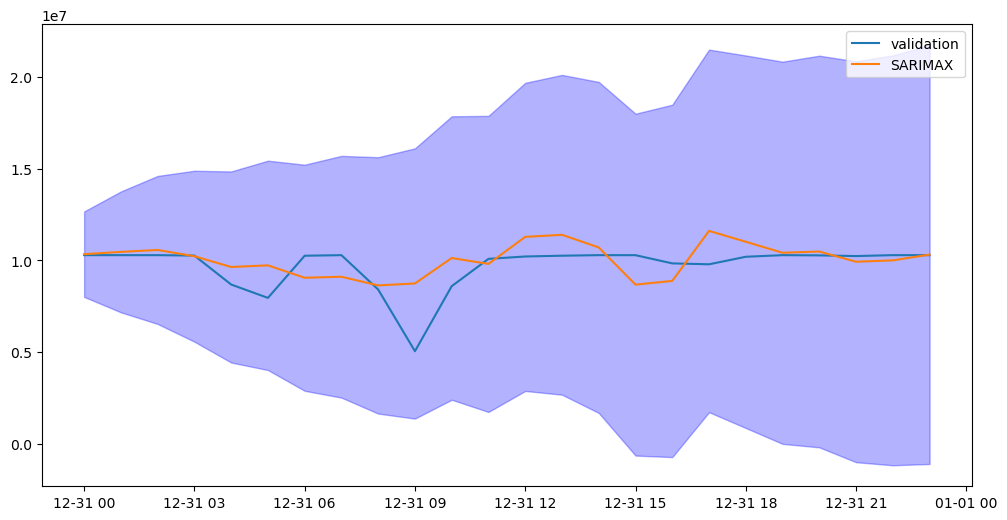

In [23]:
# plot prediction and validation

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(validation_arima.index, validation_arima['windpower'], label='validation')
plt.plot(sarimax_fcst_df.index, sarimax_fcst_df['mean'], label='SARIMAX')
plt.fill_between(sarimax_fcst_df.index, sarimax_fcst_df['mean_ci_lower'], sarimax_fcst_df['mean_ci_upper'], color='b', alpha=0.3)
plt.legend()
plt.show()


In [24]:
measure_forecast_error(validation_arima['windpower'], sarimax_fcst_df['mean'])

MAE = 841312.20 (W)
MAPE = 10.24%
R2 = 0.01


In [25]:
#convert all prediction values > 10275000.0 to 10275000.0
sarimax_fcst_df['mean'] = sarimax_fcst_df['mean'].apply(lambda x: 10275000.0 if x > 10275000.0 else x)

In [26]:
measure_forecast_error(validation_arima['windpower'], sarimax_fcst_df['mean'])

MAE = 614054.67 (W)
MAPE = 8.00%
R2 = 0.21


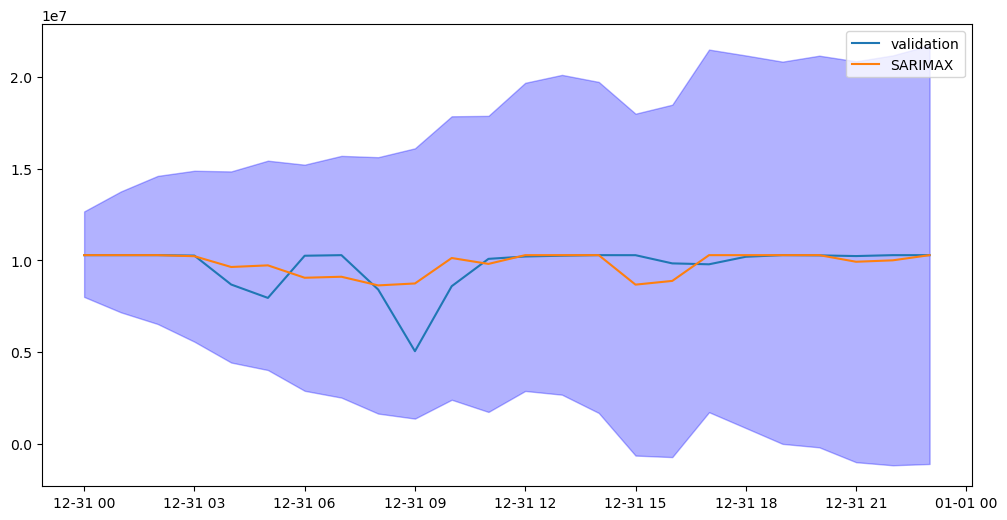

In [27]:

plt.figure(figsize=(12, 6))
plt.plot(validation_arima.index, validation_arima['windpower'], label='validation')
plt.plot(sarimax_fcst_df.index, sarimax_fcst_df['mean'], label='SARIMAX')
plt.fill_between(sarimax_fcst_df.index, sarimax_fcst_df['mean_ci_lower'], sarimax_fcst_df['mean_ci_upper'], color='b', alpha=0.3)
plt.legend()
plt.show()

In [28]:
# make predictions for the test set 
sarimax_fcst_test = sarimax_fit.get_forecast(steps=test_arima.shape[0]+24)

sarimax_fcst_test_df = sarimax_fcst_test.summary_frame()
sarimax_fcst_test_df.head()

windpower,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-12-31 00:00:00,1.032787e+07,1.189381e+06,7.996726e+06,1.265902e+07
2023-12-31 01:00:00,1.045296e+07,1.682039e+06,7.156224e+06,1.374970e+07
2023-12-31 02:00:00,1.055879e+07,2.060069e+06,6.521132e+06,1.459645e+07
2023-12-31 03:00:00,1.021653e+07,2.378763e+06,5.554244e+06,1.487882e+07
2023-12-31 04:00:00,9.629185e+06,2.659538e+06,4.416587e+06,1.484178e+07


In [33]:
sarimax_fcst_test_df.loc['2024'].index

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00',
               '2024-01-01 02:00:00', '2024-01-01 03:00:00',
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               ...
               '2024-01-05 00:00:00', '2024-01-05 01:00:00',
               '2024-01-05 02:00:00', '2024-01-05 03:00:00',
               '2024-01-05 04:00:00', '2024-01-05 05:00:00',
               '2024-01-05 06:00:00', '2024-01-05 07:00:00',
               '2024-01-05 08:00:00', '2024-01-05 09:00:00'],
              dtype='datetime64[ns]', length=106, freq='h')

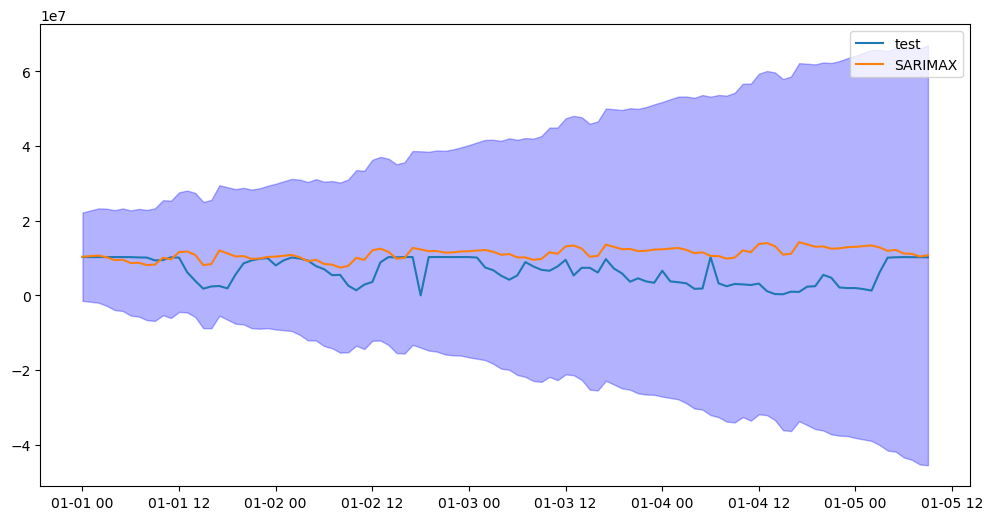

In [35]:
# plot 2024 prediction and test set
plt.figure(figsize=(12, 6))
plt.plot(test_arima.index, test_arima['windpower'], label='test')
plt.plot(sarimax_fcst_test_df.loc['2024'].index, sarimax_fcst_test_df.loc['2024']['mean'], label='SARIMAX')
plt.fill_between(sarimax_fcst_test_df.loc['2024'].index, sarimax_fcst_test_df.loc['2024']['mean_ci_lower'], sarimax_fcst_test_df.loc['2024']['mean_ci_upper'], color='b', alpha=0.3)
plt.legend()
plt.show()

In [36]:
measure_forecast_error(test_arima['windpower'], sarimax_fcst_test_df.loc['2024']['mean'])

MAE = 4892790.15 (W)
MAPE = 52341055889248662585344.00%
R2 = -2.38


In [37]:
#convert all prediction values > 10275000.0 to 10275000.0
sarimax_fcst_test_df['mean'] = sarimax_fcst_test_df['mean'].apply(lambda x: 10275000.0 if x > 10275000.0 else x)

In [38]:
measure_forecast_error(test_arima['windpower'], sarimax_fcst_test_df.loc['2024']['mean'])

MAE = 3723838.31 (W)
MAPE = 43655175633237589360640.00%
R2 = -1.14


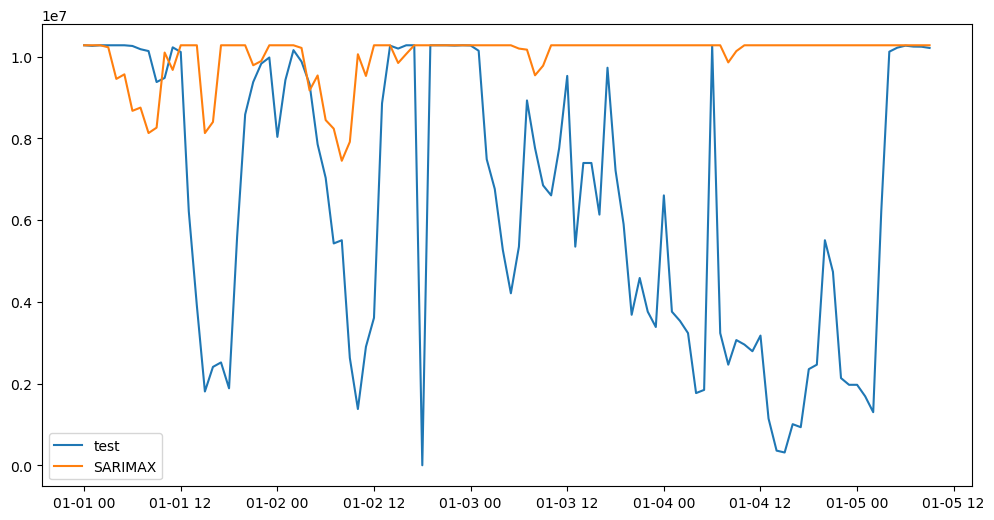

In [40]:
# plot 2024 prediction and test set
plt.figure(figsize=(12, 6))
plt.plot(test_arima.index, test_arima['windpower'], label='test')
plt.plot(sarimax_fcst_test_df.loc['2024'].index, sarimax_fcst_test_df.loc['2024']['mean'], label='SARIMAX')
plt.legend()
plt.show()

In [20]:
prediction = pd.DataFrame(arima_model.predict(n_periods=24), index=validation_arima.index)
prediction.columns = ['Prediction']
prediction.head()

,Prediction
2023-12-31 00:00:00,1.032787e+07
2023-12-31 01:00:00,1.045296e+07
2023-12-31 02:00:00,1.055879e+07
2023-12-31 03:00:00,1.021653e+07
2023-12-31 04:00:00,9.629185e+06


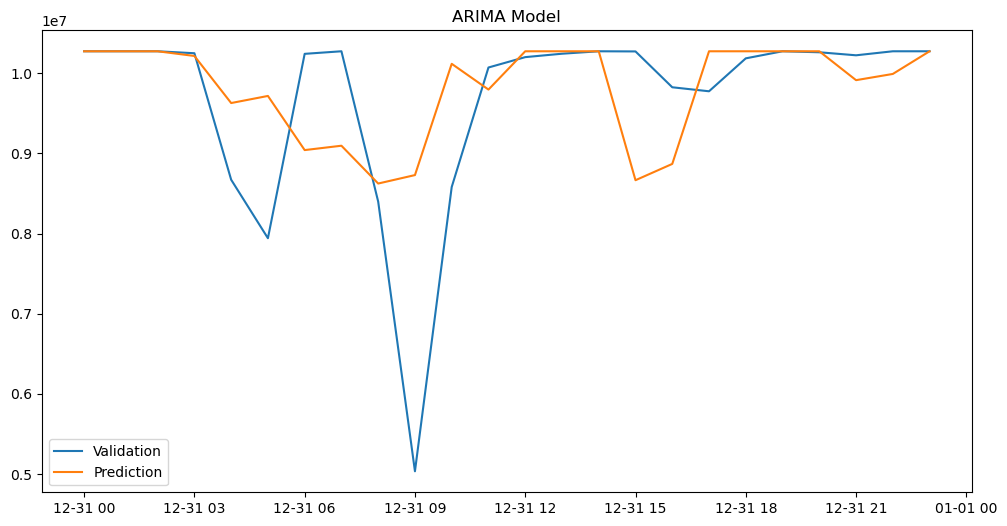

In [37]:
# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
#plt.plot(train_arima, label='Train')
plt.plot(validation_arima, label='Validation')
plt.plot(prediction, label='Prediction')
plt.title('ARIMA Model')
plt.legend()
plt.show()

In [36]:
measure_forecast_error(validation_arima, prediction)

MAE = 614054.67 (W)
MAPE = 8.00%
R2 = 0.21


In [35]:
#convert all prediction values > 10275000.0 to 10275000.0
prediction[prediction['Prediction'] > 10275000.0] = 10275000.0

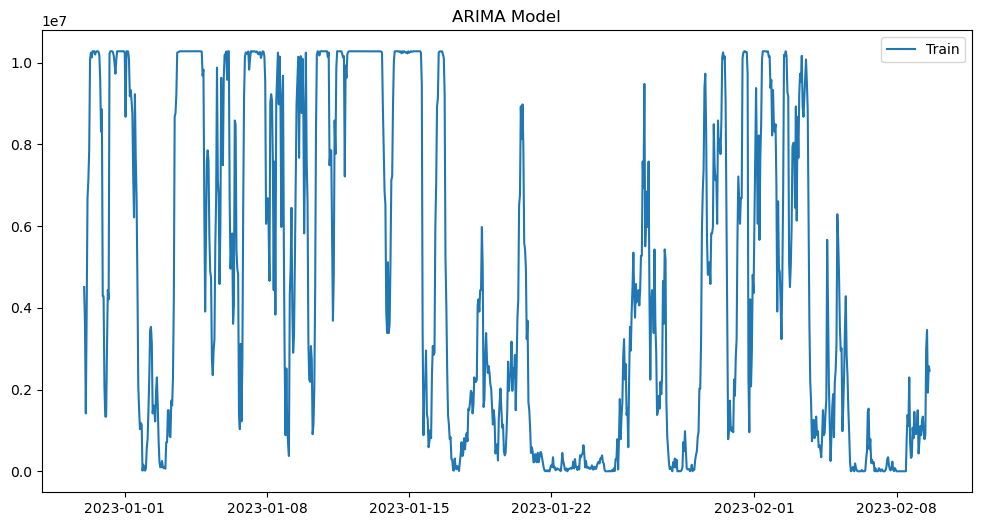

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(train_arima['temp'].head(1000), label='Train')

plt.title('ARIMA Model')
plt.legend()
plt.show()

In [30]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(train_arima)

(0.01, False)

In [32]:
#seasonality check
from pmdarima.arima.utils import ndiffs

ndiffs(train_arima, test='kpss')


1

## 3 arima

In [6]:
#run an autoarima for windspeed, temp and sealevelpressure
arima_windspeed=auto_arima(train_arima['windspeed'], start_p=2, start_q=0,
                          max_p=2, max_q=
                          1, m=24, start_P=2, max_P=2,start_Q=0,max_Q=0,start_D=1,max_D=1,
                          max_d=1,
                          seasonal=True, d=1, D=1, trace=True,
                            error_action='warn', suppress_warnings=True, 
                            stepwise=True,random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=39850.881, Time=38.78 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=43351.090, Time=2.83 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=40826.729, Time=13.39 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=43336.293, Time=3.61 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=40811.728, Time=17.46 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=39865.254, Time=47.62 sec
 ARIMA(2,1,1)(2,1,0)[24]             : AIC=39852.543, Time=71.04 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=39853.430, Time=59.63 sec
 ARIMA(2,1,0)(2,1,0)[24] intercept   : AIC=39852.879, Time=154.14 sec

Best model:  ARIMA(2,1,0)(2,1,0)[24]          
Total fit time: 408.823 seconds


In [7]:
#Best model:  ARIMA(2,1,0)(2,1,0)[24]   
arima_windspeed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8784
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 24)   Log Likelihood              -19920.440
Date:                            Tue, 19 Mar 2024   AIC                          39850.881
Time:                                    18:49:51   BIC                          39886.270
Sample:                                12-30-2022   HQIC                         39862.939
                                     - 12-30-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0401      0.008     -4.796      0.000      -0.056      -0.024
ar.L2          0.0433      0.009      4.901      0.000       0.026       0.061
ar.S.L24      -0.6633      0.008    -81.189      0.000      -0.679      -0.647
ar.S.L48      -0.3256      0.009    -38.030      0.000      -0.342      -0.309
sigma2         5.5250      0.058     94.725      0.000       5.411       5.639
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1647.18
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
prediction_windspeed = pd.DataFrame(arima_windspeed.predict(n_periods=24), index=validation_arima.index)
prediction_windspeed.columns = ['Prediction']
prediction_windspeed.head()

,Prediction
2023-12-31 00:00:00,37.517527
2023-12-31 01:00:00,38.327849
2023-12-31 02:00:00,37.871875
2023-12-31 03:00:00,37.924939
2023-12-31 04:00:00,37.719782


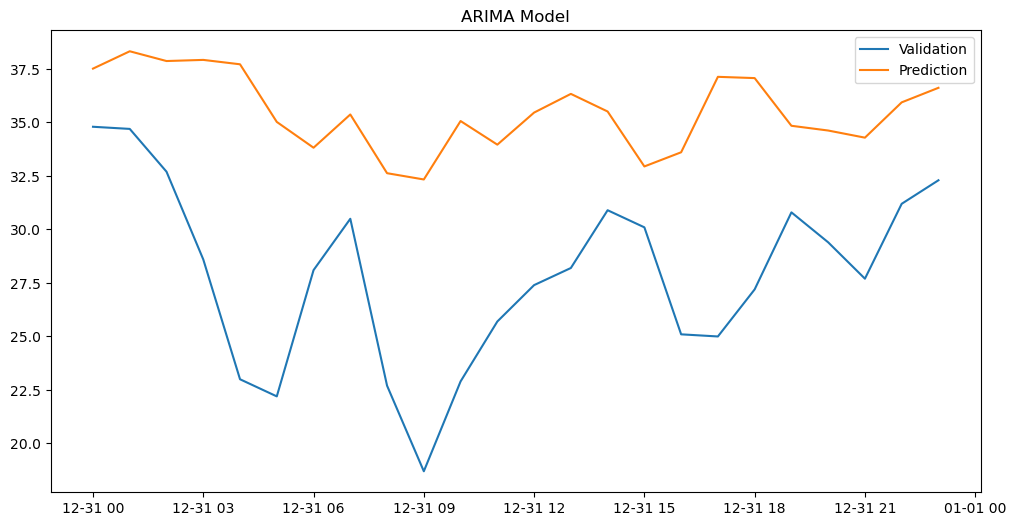

In [10]:
# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
#plt.plot(train_arima, label='Train')
plt.plot(validation_arima['windspeed'], label='Validation')
plt.plot(prediction_windspeed, label='Prediction')
plt.title('ARIMA Model')
plt.legend()
plt.show()

In [15]:
measure_forecast_error(validation_arima['windspeed'], prediction_windspeed)

MAE = 7.59 (W)
MAPE = 29.64%
R2 = -3.26
